In [ ]:
!pip install torchstain

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/NucleiSegNet'

/content/drive/MyDrive/NucleiSegNet


In [ ]:
output_base = ""
input_base = ""

In [ ]:
# !pip install opencv-python

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

from pathlib import Path
import os
import sys
import random
import warnings
import pandas as pd
import torch
from torchvision import transforms
import torchstain
# import spams

from tqdm import tqdm
from itertools import chain
import math

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
M_CHANNEL=1
Res_HEIGHT = 512  # actual image height
Res_WIDTH = 512   # actual image width
#no of patches = (input image size/ crop size)^2  per image .
pat = 4
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
np.random.seed = seed
# path where you want to store the stain normalized images
#----- # Test # ------#
Path(output_base + "/content/TestData").mkdir(parents=True, exist_ok=True)
Path(output_base + "/content/TestData/Bin").mkdir(parents=True, exist_ok=True) # for masks
Path(output_base + "/content/TestData/tis").mkdir(parents=True, exist_ok=True) # for tissues

bin_p_ts = output_base + '/content/TestData/Bin'
tis_p_ts = output_base + '/content/TestData/tis'
#----- # Train # ------#
Path(output_base + "/content/TrainData").mkdir(parents=True, exist_ok=True)
Path(output_base + "/content/TrainData/Bin").mkdir(parents=True, exist_ok=True) # for masks
Path(output_base + "/content/TrainData/tis").mkdir(parents=True, exist_ok=True) # for tissues

bin_p_tr = output_base + '/content/TrainData/Bin/'
tis_p_tr = output_base + '/content/TrainData/tis/'
#----- # Valid # ------#
Path(output_base + "/content/ValidData").mkdir(parents=True, exist_ok=True)
Path(output_base + "/content/ValidData/Bin").mkdir(parents=True, exist_ok=True) # for masks
Path(output_base + "/content/ValidData/tis").mkdir(parents=True, exist_ok=True) # for tissues

bin_p_vl = output_base + '/content/ValidData/Bin/'
tis_p_vl = output_base + '/content/ValidData/tis/'

# Give path to your dataset
Train_image_path = input_base + '/content/drive/MyDrive/NucleiSegNet/KMC_LIverSegmentation/Train/data/'
Train_mask_path = input_base + '/content/drive/MyDrive/NucleiSegNet/KMC_LIverSegmentation/Train/label/'

val_image_path = input_base + '/content/drive/MyDrive/NucleiSegNet/KMC_LIverSegmentation/Validation/data/'
val_mask_path = input_base + '/content/drive/MyDrive/NucleiSegNet/KMC_LIverSegmentation/Validation/label/'

Test_image_path = input_base + '/content/drive/MyDrive/NucleiSegNet/KMC_LIverSegmentation/Test/data/'
test_mask_path = input_base + '/content/drive/MyDrive/NucleiSegNet/KMC_LIverSegmentation/Test/label/'

# Give a reference image path for stain normalization
reference_image = input_base + '/content/drive/MyDrive/NucleiSegNet/KMC_LIverSegmentation/Test/data/0.png'


# getting the train and test ids
train_ids1 = next(os.walk(Train_image_path))[2]
train_mask_ids1 = next(os.walk(Train_mask_path))[2]
val_ids1 = next(os.walk(val_image_path))[2]
val_mask_ids1 = next(os.walk(val_mask_path))[2]
test_ids1 = next(os.walk(Test_image_path))[2]
test_mask_ids1 = next(os.walk(test_mask_path))[2]

# sorting the train and test ids
train_ids = sorted(train_ids1,key=lambda x: (os.path.splitext(x)[0]))
train_mask_ids = sorted(train_mask_ids1,key=lambda x: (os.path.splitext(x)[0]))
test_ids = sorted(test_ids1,key=lambda x: (os.path.splitext(x)[0]))
test_mask_ids = sorted(test_mask_ids1,key=lambda x: (os.path.splitext(x)[0]))
val_ids = sorted(val_ids1,key=lambda x: (os.path.splitext(x)[0]))
val_mask_ids = sorted(val_mask_ids1,key=lambda x: (os.path.splitext(x)[0]))


train_ids[:] = [tup for tup in train_ids if os.path.isfile(Train_mask_path + (os.path.splitext(tup)[0])+'.png')]
test_ids[:] = [tup for tup in test_ids if os.path.isfile(test_mask_path + (os.path.splitext(tup)[0])+'.png')]
val_ids[:] = [tup for tup in val_ids if os.path.isfile(val_mask_path + (os.path.splitext(tup)[0])+'.png')]

def stain_norm_patch():

    def read_image(path):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # opencv default color space is BGR, change it to RGB
        p = np.percentile(img, 90)
        img = np.clip(img * 255.0 / p, 0, 255).astype(np.uint8)
        return img

    def vaha(SOURCE_PATH,TARGET_PATH):
        source_image = read_image(SOURCE_PATH)
        target_image = read_image(TARGET_PATH)
        vhd = vahadane(LAMBDA1=0.01, LAMBDA2=0.01, fast_mode=1, getH_mode=0, ITER=20)
        # vhd.show_config()

        Ws, Hs = vhd.stain_separate(source_image)
        vhd.fast_mode=0;vhd.getH_mode=0;
        Wt, Ht = vhd.stain_separate(target_image)
        img = vhd.SPCN(source_image, Ws, Hs, Wt, Ht)
        return img

    def rein(src):
      target_img = reference_image
      target = cv2.cvtColor(cv2.imread(target_img), cv2.COLOR_BGR2RGB)
      to_transform = cv2.cvtColor(cv2.imread(src), cv2.COLOR_BGR2RGB)

      T = transforms.Compose([
          transforms.ToTensor(),
          transforms.Lambda(lambda x: x*255)
      ])

      torch_normalizer = torchstain.normalizers.MacenkoNormalizer(backend='torch')
      torch_normalizer.fit(T(target))

      t_to_transform = T(to_transform)
      norm, H, E = torch_normalizer.normalize(I=t_to_transform, stains=True)
      return norm

    # Get and resize train images and masks
    def train():
        X_train = np.zeros((len(train_ids)*pat, IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.float32)
        Y_train = np.zeros((len(train_ids)*pat, IMG_HEIGHT, IMG_WIDTH,1), dtype=bool)
        print('stain normalizing and cropping patches of train images and masks ... ')
        sys.stdout.flush()
        for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
            path = Train_mask_path + (os.path.splitext(id_)[0])+'.png'
            img = rein(Train_image_path + id_)
            mask_ = cv2.imread(path,0)
            _, mask_ = cv2.threshold(mask_, 128, 255, cv2.THRESH_BINARY)
            mask_ = np.expand_dims(mask_, -1)
            temp_list = []
            temp_list_mask = []
            for i in range (int(math.pow(pat,0.5))):
                for j in range(int(math.pow(pat,0.5))):
                    if i<(int(math.pow(pat,0.5))-1):
                        if j<(int(math.pow(pat,0.5))-1):
                            crop_img1 = img[i*IMG_HEIGHT:i*IMG_HEIGHT+IMG_HEIGHT, j*IMG_WIDTH:j*IMG_WIDTH+IMG_WIDTH]
                            crop_mask1 = mask_[i*IMG_HEIGHT:i*IMG_HEIGHT+IMG_HEIGHT, j*IMG_WIDTH:j*IMG_WIDTH+IMG_WIDTH]
                            temp_list.append(crop_img1)
                            temp_list_mask.append(crop_mask1)
                        elif j==(int(math.pow(pat,0.5))-1):
                            crop_img2 = img[i*IMG_HEIGHT:i*IMG_HEIGHT+IMG_HEIGHT, j*IMG_WIDTH-0:j*IMG_WIDTH+IMG_WIDTH-0]
                            crop_mask2 = mask_[i*IMG_HEIGHT:i*IMG_HEIGHT+IMG_HEIGHT, j*IMG_WIDTH-0:j*IMG_WIDTH+IMG_WIDTH-0]
                            temp_list.append(crop_img2)
                            temp_list_mask.append(crop_mask2)
                    elif i==(int(math.pow(pat,0.5))-1):
                        if j<(int(math.pow(pat,0.5))-1):
                            crop_img3 = img[i*IMG_HEIGHT-0:i*IMG_HEIGHT+IMG_HEIGHT-0, j*IMG_WIDTH:j*IMG_WIDTH+IMG_WIDTH]
                            crop_mask3 = mask_[i*IMG_HEIGHT-0:i*IMG_HEIGHT+IMG_HEIGHT-0, j*IMG_WIDTH:j*IMG_WIDTH+IMG_WIDTH]
                            temp_list.append(crop_img3)
                            temp_list_mask.append(crop_mask3)
                        elif j==(int(math.pow(pat,0.5))-1):
                            crop_img4 = img[i*IMG_HEIGHT-0:i*IMG_HEIGHT+IMG_HEIGHT-0, j*IMG_WIDTH-0:j*IMG_WIDTH+IMG_WIDTH-0]
                            crop_mask4 = mask_[i*IMG_HEIGHT-0:i*IMG_HEIGHT+IMG_HEIGHT-0, j*IMG_WIDTH-0:j*IMG_WIDTH+IMG_WIDTH-0]
                            temp_list.append(crop_img4)
                            temp_list_mask.append(crop_mask4)

            for t in range(0,pat):
                X_train[n*pat+t] = temp_list[t]
                Y_train[n*pat+t] = temp_list_mask[t]
                # mask = np.maximum(mask, mask_)
        return X_train, Y_train


    def val():
        X_val = np.zeros((len(val_ids)*pat, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
        Y_val = np.zeros((len(val_ids)*pat, IMG_HEIGHT, IMG_WIDTH,1), dtype=bool)
        print('stain normalizing and cropping patches of validation images and masks ... ')
        sys.stdout.flush()
        for m, id_ in tqdm(enumerate(val_ids), total=len(val_ids)):

            path = val_mask_path + (os.path.splitext(id_)[0])+'.png'
            val_img = rein(val_image_path + id_)
            val_mask_ = cv2.imread(path,0)
            _, val_mask_ = cv2.threshold(val_mask_, 128, 255, cv2.THRESH_BINARY)
            val_mask_ = np.expand_dims(val_mask_, -1)

            temp_list = []
            temp_list_mask = []
            for i in range (int(math.pow(pat,0.5))):
                for j in range(int(math.pow(pat,0.5))):
                    if i<(int(math.pow(pat,0.5))-1):
                        if j<(int(math.pow(pat,0.5))-1):
                            crop_val_img1 = val_img[i*IMG_HEIGHT:i*IMG_HEIGHT+IMG_HEIGHT, j*IMG_WIDTH:j*IMG_WIDTH+IMG_WIDTH]
                            crop_mask1 = val_mask_[i*IMG_HEIGHT:i*IMG_HEIGHT+IMG_HEIGHT, j*IMG_WIDTH:j*IMG_WIDTH+IMG_WIDTH]
                            temp_list.append(crop_val_img1)
                            temp_list_mask.append(crop_mask1)
                        elif j==(int(math.pow(pat,0.5))-1):
                            crop_val_img2 = val_img[i*IMG_HEIGHT:i*IMG_HEIGHT+IMG_HEIGHT, j*IMG_WIDTH-0:j*IMG_WIDTH+IMG_WIDTH-0]
                            crop_mask2 = val_mask_[i*IMG_HEIGHT:i*IMG_HEIGHT+IMG_HEIGHT, j*IMG_WIDTH-0:j*IMG_WIDTH+IMG_WIDTH-0]
                            temp_list.append(crop_val_img2)
                            temp_list_mask.append(crop_mask2)
                    elif i==(int(math.pow(pat,0.5))-1):
                        if j<(int(math.pow(pat,0.5))-1):
                            crop_val_img3 = val_img[i*IMG_HEIGHT-0:i*IMG_HEIGHT+IMG_HEIGHT-0, j*IMG_WIDTH:j*IMG_WIDTH+IMG_WIDTH]
                            crop_mask3 = val_mask_[i*IMG_HEIGHT-0:i*IMG_HEIGHT+IMG_HEIGHT-0, j*IMG_WIDTH:j*IMG_WIDTH+IMG_WIDTH]
                            temp_list.append(crop_val_img3)
                            temp_list_mask.append(crop_mask3)
                        elif j==(int(math.pow(pat,0.5))-1):
                            crop_val_img4 = val_img[i*IMG_HEIGHT-0:i*IMG_HEIGHT+IMG_HEIGHT-0, j*IMG_WIDTH-0:j*IMG_WIDTH+IMG_WIDTH-0]
                            crop_mask4 = val_mask_[i*IMG_HEIGHT-0:i*IMG_HEIGHT+IMG_HEIGHT-0, j*IMG_WIDTH-0:j*IMG_WIDTH+IMG_WIDTH-0]
                            temp_list.append(crop_val_img4)
                            temp_list_mask.append(crop_mask4)

            for t in range(0,pat):
                X_val[m*pat+t] = temp_list[t]
                Y_val[m*pat+t] = temp_list_mask[t]
                # mask = np.maximum(mask, mask_)
        return X_val, Y_val


    def test():
        X_test = np.zeros((len(test_ids)*pat, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
        Y_test = np.zeros((len(test_ids)*pat, IMG_HEIGHT, IMG_WIDTH,1), dtype=bool)
        print('stain normalizing and cropping patches of test images ... ')
        sys.stdout.flush()

        for s, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):

            path = test_mask_path + (os.path.splitext(id_)[0])+'.png'
            img = rein(Test_image_path + id_)
            test_mask_ = cv2.imread(path,0)
            _, test_mask_ = cv2.threshold(test_mask_, 128, 255, cv2.THRESH_BINARY)
            test_mask_ = np.expand_dims(test_mask_, -1)

            temp_list = []
            temp_list_mask = []
            for i in range (int(math.pow(pat,0.5))):
                for j in range(int(math.pow(pat,0.5))):
                    if i<(int(math.pow(pat,0.5))-1):
                        if j<(int(math.pow(pat,0.5))-1):
                            crop_img1 = img[i*IMG_HEIGHT:i*IMG_HEIGHT+IMG_HEIGHT, j*IMG_WIDTH:j*IMG_WIDTH+IMG_WIDTH]
                            crop_mask1 = test_mask_[i*IMG_HEIGHT:i*IMG_HEIGHT+IMG_HEIGHT, j*IMG_WIDTH:j*IMG_WIDTH+IMG_WIDTH]
                            temp_list.append(crop_img1)
                            temp_list_mask.append(crop_mask1)
                        elif j==(int(math.pow(pat,0.5))-1):
                            crop_img2 = img[i*IMG_HEIGHT:i*IMG_HEIGHT+IMG_HEIGHT, j*IMG_WIDTH-0:j*IMG_WIDTH+IMG_WIDTH-0]
                            crop_mask2 = test_mask_[i*IMG_HEIGHT:i*IMG_HEIGHT+IMG_HEIGHT, j*IMG_WIDTH-0:j*IMG_WIDTH+IMG_WIDTH-0]
                            temp_list.append(crop_img2)
                            temp_list_mask.append(crop_mask2)
                    elif i==(int(math.pow(pat,0.5))-1):
                        if j<(int(math.pow(pat,0.5))-1):
                            crop_img3 = img[i*IMG_HEIGHT-0:i*IMG_HEIGHT+IMG_HEIGHT-0, j*IMG_WIDTH:j*IMG_WIDTH+IMG_WIDTH]
                            crop_mask3 = test_mask_[i*IMG_HEIGHT-0:i*IMG_HEIGHT+IMG_HEIGHT-0, j*IMG_WIDTH:j*IMG_WIDTH+IMG_WIDTH]
                            temp_list.append(crop_img3)
                            temp_list_mask.append(crop_mask3)
                        elif j==(int(math.pow(pat,0.5))-1):
                            crop_img4 = img[i*IMG_HEIGHT-0:i*IMG_HEIGHT+IMG_HEIGHT-0, j*IMG_WIDTH-0:j*IMG_WIDTH+IMG_WIDTH-0]
                            crop_mask4 = test_mask_[i*IMG_HEIGHT-0:i*IMG_HEIGHT+IMG_HEIGHT-0, j*IMG_WIDTH-0:j*IMG_WIDTH+IMG_WIDTH-0]
                            temp_list.append(crop_img4)
                            temp_list_mask.append(crop_mask4)

            for t in range(0,pat):
                X_test[s*pat+t] = temp_list[t]
                Y_test[s*pat+t] = temp_list_mask[t]
                # mask = np.maximum(mask, mask_)
        return X_test, Y_test

    train1 = train()
    X_train = train1[0]
    Y_train = train1[1]

    val1 = val()
    X_val = val1[0]
    Y_val = val1[1]

    test1 = test()
    X_test = test1[0]
    Y_test = test1[1]

    # this will save the stain normalized patches into the created paths above
    #------------------------#TEST#---------------------------------#

    for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
        id_1 = os.path.splitext(id_)[0]
        for j in range(pat):
            j1 = "{0:0=2d}".format(j)
            img_t = X_test[n*pat+j]
            imgs_b = Y_test[n*pat+j]*255
            # img_t = X_test[n]
            # imgs_b = np.reshape(Y_test[n]*255,(IMG_WIDTH,IMG_HEIGHT))
            filename1 = '{}/{}_{}.png'.format(tis_p_ts,id_1,j1)
            cv2.imwrite(filename1, cv2.cvtColor(img_t, cv2.COLOR_BGR2RGB))
            filename2 = '{}/{}_{}.png'.format(bin_p_ts,id_1,j1)
            cv2.imwrite(filename2, imgs_b)
    #------------------------#VAL#-------------------------------#

    for n, id_ in tqdm(enumerate(val_ids), total=len(val_ids)):
        id_1 = os.path.splitext(id_)[0]

        for j in range(pat):
            j1 = "{0:0=2d}".format(j)
            img_t = X_val[n*pat+j]
            imgs_b = Y_val[n*pat+j]*255
            filename1 = '{}/{}_{}.png'.format(tis_p_vl,id_1,j1)
            cv2.imwrite(filename1,cv2.cvtColor(img_t, cv2.COLOR_BGR2RGB))    #cv2.cvtColor(img_t, cv2.COLOR_BGR2RGB)
            filename2 = '{}/{}_{}.png'.format(bin_p_vl,id_1,j1)
            cv2.imwrite(filename2, imgs_b)
    # ------------------------#TRAIN#-------------------------------#

    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        id_1 = os.path.splitext(id_)[0]

        for j in range(pat):
            j1 = "{0:0=2d}".format(j)
            img_t = X_train[n*pat+j]
            imgs_b = Y_train[n*pat+j]*255
            filename1 = '{}/{}_{}.png'.format(tis_p_tr,id_1,j1)
            cv2.imwrite(filename1, cv2.cvtColor(img_t, cv2.COLOR_BGR2RGB))  #cv2.cvtColor(img_t, cv2.COLOR_BGR2RGB)
            filename2 = '{}/{}_{}.png'.format(bin_p_tr,id_1,j1)
            cv2.imwrite(filename2, imgs_b)
def patch_join(out_im):
    num_im = len(out_im)//pat
    num_pat = int(pat**0.5)
    out_concat = np.zeros((Res_HEIGHT, Res_WIDTH, 1), dtype=np.uint8)
    # Y_concat = np.zeros((Res_HEIGHT, Res_WIDTH, 1), dtype=np.bool)

    out_full = np.zeros((num_im,Res_HEIGHT, Res_WIDTH, 1), dtype=np.uint8)
    # Y_full = np.zeros((num_im,Res_HEIGHT, Res_WIDTH, 1), dtype=np.bool)


    for k in range(num_im):
        sec1 = []
        y_sec1 = []
        for l in range(pat):

            sec = out_im[k*pat+l]
            sec1.append(sec)

        for i in range(int(num_pat)):
            for j in range(int(num_pat)):

                if i<num_pat-1:
                    if j<num_pat-1:
                        out_concat[i*IMG_HEIGHT:i*IMG_HEIGHT+IMG_HEIGHT, j*IMG_WIDTH:j*IMG_WIDTH+IMG_WIDTH] = sec1[i*num_pat+j]

                    elif j==num_pat-1:
                        out_concat[i*IMG_HEIGHT:i*IMG_HEIGHT+IMG_HEIGHT, j*IMG_WIDTH-0:j*IMG_WIDTH+IMG_WIDTH-0] = sec1[i*num_pat+j]

                elif i==num_pat-1:
                    if j<num_pat-1:
                        out_concat[i*IMG_HEIGHT-0:i*IMG_HEIGHT+IMG_HEIGHT-0, j*IMG_WIDTH:j*IMG_WIDTH+IMG_WIDTH] = sec1[i*num_pat+j]

                    elif j==num_pat-1:
                        out_concat[i*IMG_HEIGHT-0:i*IMG_HEIGHT+IMG_HEIGHT-0, j*IMG_WIDTH-0:j*IMG_WIDTH+IMG_WIDTH-0] = sec1[i*num_pat+j]

        out_full[k] = out_concat

    return out_full,test_ids


stain_norm_patch()

stain normalizing and cropping patches of test images ... 


100%|██████████| 3/3 [00:00<00:00, 18.43it/s]


In [ ]:
import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.backend import *

from tensorflow.keras.losses import binary_crossentropy

  ##### Metrices & Loss #####
#------------- Metrice-------------
def f1_score1(y_true,y_pred):
    smooth=1
    y_true = cast(y_true, dtype='float32')
    y_pred = cast(y_pred, dtype='float32')
    y_true_f = flatten(y_true)
    y_pred_f = flatten(y_pred)
    intersection = sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (sum(y_true_f) + sum(y_pred_f) + smooth)
#----------------------------------
# -------------Loss----------------
def dice_loss(y_true, y_pred):
    smooth=1
    y_true_f = flatten(y_true)
    y_pred_f = flatten(y_pred)
    y_true_f = cast(y_true_f, dtype='float32')
    y_pred_f = cast(y_pred_f, dtype='float32')
    intersection = sum(y_true_f * y_pred_f)
    return 1-(2. * intersection + smooth) / (sum(y_true_f) + sum(y_pred_f) + smooth)

def loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    def dice_coef_loss(y_true, y_pred):
        return dice_loss(y_true, y_pred)

    def jaccard_distance_loss(y_true, y_pred, smooth=100):
        intersection = sum(abs(y_true * y_pred), axis=-1)
        sum_ = sum(abs(y_true) + abs(y_pred), axis=-1)
        jac = (intersection + smooth) / (sum_ - intersection + smooth)
        return (1 - jac) * smooth

    return (jaccard_distance_loss(y_true, y_pred) * dice_coef_loss(y_true, y_pred))/(jaccard_distance_loss(y_true, y_pred) + dice_coef_loss(y_true, y_pred))

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
#-----------------------------------
#####################

In [ ]:
og_lr = 0.001
modified_lr = 0.001

In [ ]:
import tensorflow as tf
from tensorflow.keras import *
from  tensorflow.keras.initializers import *
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
import numpy as np

from tensorflow.keras.backend import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import *

class Slice(Layer):
    def __init__(self, r1, r2):
        super().__init__()
        self.r1 = r1
        self.r2 = r2

    def call(self, x):
        return tf.slice(x, self.r1, self.r2)
    def get_config(self):
        config = super().get_config()
        config.update({
        })
        return config


def create_model():

    ## Crop and Merge Layers ##
    def CropAndMerge(Input1, Input2):
            """
            Crop input1 so that it matches input2 and then
            return the concatenation of both channels.
            """
            Size1_x = (Input1).shape[1]
            Size2_x = (Input2).shape[1]

            Size1_y = (Input1).shape[2]
            Size2_y = (Input2).shape[2]

            diff_x = tf.divide(tf.subtract(Size1_x, Size2_x), 2)
            diff_y = tf.divide(tf.subtract(Size1_y, Size2_y), 2)
            diff_x = tf.cast(diff_x, tf.int32)
            Size2_x = tf.cast(Size2_x, tf.int32)
            diff_y = tf.cast(diff_y, tf.int32)
            Size2_y = tf.cast(Size2_y, tf.int32)
            crop = Slice([0, diff_x, diff_y, 0], [-1, Size2_x, Size2_y, -1])(Input1)
            concat = tf.keras.layers.concatenate([crop, Input2], axis=3)

            return concat
    #-------------------------------------
    ## Attention Mechanism ##
    def attention_gt(input_x,input_g, fil_las):
        input_size = input_x.shape
        fil_int = fil_las//2

        input_g = Conv2D(filters=fil_las,kernel_size=(1,1), strides=(1, 1), activation='relu', padding='same',use_bias=True,
            bias_initializer=Constant(0.1))(input_g)

        theta_x = Conv2D(filters=fil_int,kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same',use_bias=True,
                      bias_initializer=Constant(0.1))(input_x)

        theta_x_size  =  theta_x.shape

        phi_g = Conv2D(filters=fil_int,kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same',use_bias=True,
                  bias_initializer=Constant(0.1))(input_g)

        phi_g_u = UpSampling2D(size=(2, 2), interpolation='bilinear')(phi_g)
        f = tf.keras.activations.relu(layers.Add()([theta_x,phi_g_u]))

        # psi_f = Conv2D(filters=fil_las,kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same',use_bias=True,
                  # bias_initializer=Constant(0.1))(f)


        psi_f = Conv2D(filters=fil_las, kernel_size=(1,1), strides=(1, 1),activation='relu',padding='same')(f)
        psi_f = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.0),gamma_initializer=Constant(1.0),momentum=0.5)(psi_f)

        sigm_psi_f = tf.keras.activations.sigmoid(psi_f)

        expand = Reshape(target_shape=input_size[-3:])(sigm_psi_f)


        y = layers.Multiply()([expand , input_x])

        return y
    ## Conv Block
    def conv_block(input, filters):

        x = Conv2D(filters,kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same',use_bias=True, bias_initializer=Constant(0.1))(input)
        x = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.0),gamma_initializer=Constant(1.0),momentum=0.5)(x)
        x = Conv2D(filters,kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same',use_bias=True, bias_initializer=Constant(0.1))(x)
        x = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.0),gamma_initializer=Constant(1.0),momentum=0.5)(x)

        return x
    ## Bottleneck Block
    def bottleneck_block(input, filters):

        x = Conv2D(filters,kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same',use_bias=True,
                  bias_initializer=Constant(0.1))(input)
        x = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.0),
                              gamma_initializer=Constant(1.0),momentum=0.5)(x)
        x = Conv2D(filters,kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same',use_bias=True,
                  bias_initializer=Constant(0.1))(x)
        x = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.0),
                              gamma_initializer=Constant(1.0),momentum=0.5)(x)
        x = Conv2D(filters,kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same',use_bias=True,
                  bias_initializer=Constant(0.1))(x)
        x = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.0),
                              gamma_initializer=Constant(1.0),momentum=0.5)(x)

        return x

    ## Robust Residual block
    def robust_residual_block(input, filters_inp):

        x1 = Conv2D(filters=filters_inp,kernel_size=(3,3), strides=(1, 1), padding='same',activation='relu',
                    use_bias=True, bias_initializer=Constant(0.1))(input)
        x1 = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.01),
                                gamma_initializer=Constant(1.0),momentum=0.5)(x1)

        x2 = SeparableConv2D(filters=filters_inp,kernel_size=(3,3), strides=(1, 1),activation='relu',padding='same',
                            use_bias=True,depthwise_initializer='glorot_uniform',pointwise_initializer='glorot_uniform',
                            bias_initializer=Constant(0.1),depth_multiplier=1)(x1)
        x2 = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.01),
                                gamma_initializer=Constant(1.0),momentum=0.5)(x2)

        x3 = Conv2D(filters=filters_inp,kernel_size=(3,3), strides=(1, 1), padding='same',activation='relu',
                    use_bias=True, bias_initializer=Constant(0.1))(x2)
        x3 = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.01),
                                gamma_initializer=Constant(1.0),momentum=0.5)(x3)

        x = tf.keras.layers.concatenate([input,x3])
        x = Conv2D(filters=filters_inp,kernel_size=(3,3), strides=(1, 1),activation='relu', padding='same',use_bias=True, bias_initializer=Constant(0.1))(x)
        x = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.01),
                              gamma_initializer=Constant(1.0),momentum=0.5)(x)

        return x


    # def skip_connection(input, filters_inp):
    #     x1 = skip_connection_robust_residual(input, filters_inp)
    #     x1 = skip_connection_robust

    ## Attention Block ##
    def attention_decoder_block(input, filt,conc):
        atten_b = attention_gt(input_x=conc,input_g=input, fil_las=filt)
        x_ct = Conv2DTranspose(filters=filt, kernel_size=(2, 2),activation='relu', strides=(2, 2), padding='same',bias_initializer=Constant(0.1),use_bias=True)(input)
        x = CropAndMerge(Input1=x_ct,Input2=atten_b)
        return x

    def nuclei_segnet(
        input_shape,
        num_classes=1,
        output_activation='sigmoid'):

        inputs = Input(input_shape)

        filters = [32,64,128,256,512]


        # for l in range(num_layers):
        x_conv1 = robust_residual_block(inputs, filters[0])
        x_pool1 = MaxPooling2D((2, 2), strides=(2, 2),padding="same")(x_conv1)
        x_conv2 = robust_residual_block(x_pool1, filters[1])
        x_pool2 = MaxPooling2D((2, 2), strides=(2, 2),padding="same")(x_conv2)
        x_conv3 = robust_residual_block(x_pool2, filters[2])
        x_pool3 = MaxPooling2D((2, 2), strides=(2, 2),padding="same")(x_conv3)
        x_conv4 = robust_residual_block(x_pool3, filters[3])
        x_pool4 = MaxPooling2D((2, 2), strides=(2, 2),padding="same")(x_conv4)
        x_conv5 = bottleneck_block(x_pool4, filters[4])

    # upsampling in the form of convtranspose

        x_tconv5 = attention_decoder_block(x_conv5, filters[3],x_conv4)
        u_conv4 = conv_block(x_tconv5, filters[3])
        x_tconv4 = attention_decoder_block(u_conv4, filters[2],x_conv3)
        u_conv3 = conv_block(x_tconv4, filters[2])
        x_tconv3 = attention_decoder_block(u_conv3, filters[1],x_conv2)
        u_conv2 = conv_block(x_tconv3, filters[1])
        x_tconv2 = attention_decoder_block(u_conv2, filters[0],x_conv1)
        u_conv1 = conv_block(x_tconv2, filters[0])

        outputs = Conv2D(num_classes, kernel_size=(1,1), strides=(1,1), activation=output_activation, padding='same') (u_conv1)

        model = Model(inputs=[inputs], outputs=[outputs])
        return model

    model = nuclei_segnet(
                  input_shape=(256,256,3),
                  num_classes=1,
                  output_activation='sigmoid')

    adam = optimizers.Adam(learning_rate = og_lr)
    model.compile(optimizer = adam,loss=loss,metrics=[f1_score1])

    return model

In [ ]:
# !pip install tensorflow_addons

In [ ]:
import os
# os.environ["KERAS_BACKEND"] = "jax"
import tensorflow as tf
from tensorflow.keras import *

input_shape = (256, 256, 3)
image_size = input_shape[0]
patch_size_t = 8  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size_t) ** 2
projection_dim = 256
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 1
mlp_head_units = [
    512,
    256,
]



def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x



class Patches(layers.Layer):
    def __init__(self, patch_size_t):
        super().__init__()
        self.patch_size_t = patch_size_t

    def call(self, images):
        input_shape = tf.shape(images)  # Direct shape access
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]

        num_patches_h = height // self.patch_size_t
        num_patches_w = width // self.patch_size_t

        patches = tf.image.extract_patches(
            images,
            sizes=[1, self.patch_size_t, self.patch_size_t, 1],
            strides=[1, self.patch_size_t, self.patch_size_t, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        print(patches)
        patch_dims = patches.shape[-1]
        # tf.reshape(patches, [batch_size, -1, patch_dims])
        patches = tf.reshape(
            patches,
            (batch_size, num_patches_h * num_patches_w, self.patch_size_t * self.patch_size_t * channels)
        )

        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size_t": self.patch_size_t})
        return config



class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.expand_dims(
            tf.range(start=0, limit=self.num_patches, delta=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded


    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config



def vit(inputs):
    # Create patches.
    patches = Patches(patch_size_t)(inputs)
    print(patches.shape)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    return encoded_patches


In [ ]:
import tensorflow as tf
from tensorflow.keras import *
from  tensorflow.keras.initializers import *
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
import numpy as np

from tensorflow.keras.backend import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import *


def create_model_modified():

    ## Crop and Merge Layers ##
    def CropAndMerge(Input1, Input2):
            """
            Crop input1 so that it matches input2 and then
            return the concatenation of both channels.
            """
            Size1_x = (Input1).shape[1]
            Size2_x = (Input2).shape[1]

            Size1_y = (Input1).shape[2]
            Size2_y = (Input2).shape[2]

            diff_x = tf.divide(tf.subtract(Size1_x, Size2_x), 2)
            diff_y = tf.divide(tf.subtract(Size1_y, Size2_y), 2)
            diff_x = tf.cast(diff_x, tf.int32)
            Size2_x = tf.cast(Size2_x, tf.int32)
            diff_y = tf.cast(diff_y, tf.int32)
            Size2_y = tf.cast(Size2_y, tf.int32)
            crop = Slice([0, diff_x, diff_y, 0], [-1, Size2_x, Size2_y, -1])(Input1)
            concat = tf.keras.layers.concatenate([crop, Input2], axis=3)

            return concat


    #-------------------------------------
    ## Attention Mechanism ##
    def attention_gt(input_x,input_g, fil_las):
        input_size = input_x.shape
        fil_int = fil_las//2

        input_g = Conv2D(filters=fil_las,kernel_size=(1,1), strides=(1, 1), activation='relu', padding='same',use_bias=True,
            bias_initializer=Constant(0.1))(input_g)

        theta_x = Conv2D(filters=fil_int,kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same',use_bias=True,
                      bias_initializer=Constant(0.1))(input_x)

        theta_x_size  =  theta_x.shape

        phi_g = Conv2D(filters=fil_int,kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same',use_bias=True,
                  bias_initializer=Constant(0.1))(input_g)

        phi_g_u = UpSampling2D(size=(2, 2), interpolation='bilinear')(phi_g)
        f = tf.keras.activations.relu(layers.Add()([theta_x,phi_g_u]))

        # psi_f = Conv2D(filters=fil_las,kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same',use_bias=True,
                  # bias_initializer=Constant(0.1))(f)


        psi_f = Conv2D(filters=fil_las, kernel_size=(1,1), strides=(1, 1),activation='relu',padding='same')(f)
        psi_f = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.0),gamma_initializer=Constant(1.0),momentum=0.5)(psi_f)

        sigm_psi_f = tf.keras.activations.sigmoid(psi_f)

        expand = Reshape(target_shape=input_size[-3:])(sigm_psi_f)


        y = layers.Multiply()([expand , input_x])

        return y

    ## Conv Block
    def conv_block(input, filters):

        x = Conv2D(filters,kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same',use_bias=True, bias_initializer=Constant(0.1))(input)
        x = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.0),gamma_initializer=Constant(1.0),momentum=0.5)(x)
        x = Conv2D(filters,kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same',use_bias=True, bias_initializer=Constant(0.1))(x)
        x = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.0),gamma_initializer=Constant(1.0),momentum=0.5)(x)

        return x
    ## Bottleneck Block
    def bottleneck_block(input, filters):

        x = Conv2D(filters,kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same',use_bias=True,
                  bias_initializer=Constant(0.1))(input)
        x = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.0),
                              gamma_initializer=Constant(1.0),momentum=0.5)(x)
        x = Conv2D(filters,kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same',use_bias=True,
                  bias_initializer=Constant(0.1))(x)
        x = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.0),
                              gamma_initializer=Constant(1.0),momentum=0.5)(x)
        x = Conv2D(filters,kernel_size=(3,3), strides=(1, 1), activation='relu', padding='same',use_bias=True,
                  bias_initializer=Constant(0.1))(x)
        x = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.0),
                              gamma_initializer=Constant(1.0),momentum=0.5)(x)

        return x

    ## Robust Residual block
    def robust_residual_block(input, filters_inp):
        x1 = Conv2D(filters=filters_inp,kernel_size=(3,3), strides=(1, 1), padding='same',activation='relu',
                    use_bias=True, bias_initializer=Constant(0.1))(input)
        x1 = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.01),
                                gamma_initializer=Constant(1.0),momentum=0.5)(x1)

        x2 = SeparableConv2D(filters=filters_inp,kernel_size=(3,3), strides=(1, 1),activation='relu',padding='same',
                            use_bias=True,depthwise_initializer='glorot_uniform',pointwise_initializer='glorot_uniform',
                            bias_initializer=Constant(0.1),depth_multiplier=1)(x1)
        x2 = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.01),
                                gamma_initializer=Constant(1.0),momentum=0.5)(x2)

        x3 = Conv2D(filters=filters_inp,kernel_size=(3,3), strides=(1, 1), padding='same',activation='relu',
                    use_bias=True, bias_initializer=Constant(0.1))(x2)
        x3 = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.01),
                                gamma_initializer=Constant(1.0),momentum=0.5)(x3)

        x = tf.keras.layers.concatenate([input,x3],axis=-1)
        x = Conv2D(filters=filters_inp,kernel_size=(3,3), strides=(1, 1),activation='relu', padding='same',use_bias=True, bias_initializer=Constant(0.1))(x)
        x = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.01),
                              gamma_initializer=Constant(1.0),momentum=0.5)(x)

        return x


    ## Attention Block ##
    def attention_decoder_block(input, filt,conc):
        atten_b = attention_gt(input_x=conc,input_g=input, fil_las=filt)
        x_ct = Conv2DTranspose(filters=filt, kernel_size=(2, 2),activation='relu', strides=(2, 2), padding='same',bias_initializer=Constant(0.1),use_bias=True)(input)
        x = CropAndMerge(Input1=x_ct,Input2=atten_b)
        return x

        return spatial_attention

    # def fuse(w_g, w_x, channel):
    #     w_add = layers.Add()([w_g, w_x])
    #     w_c_avg_pool = GlobalAveragePooling2D()(w_add)
    #     b = mlp(w_c_avg_pool, [2*channel, channel], 0.1)
    #     b = tf.keras.activations.sigmoid(b)
    #     b = Reshape(target_shape = (1, 1, channel))(b)
    #     n_w_g = layers.Multiply()([w_g, b])
    #     n_w_x = layers.Multiply()([w_x, b])
    #     f = add([n_w_g, n_w_x])
    #     return f

    def fuse(w_g, w_x, channel):
        w_add = layers.Add()([w_g, w_x])

        x1 = SeparableConv2D(filters=channel,kernel_size=(3,3), strides=(1, 1),activation='relu',padding='same',
                            use_bias=True,depthwise_initializer='glorot_uniform',pointwise_initializer='glorot_uniform',
                            bias_initializer=Constant(0.1),depth_multiplier=1)(w_add)
        x1 = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.01),
                                gamma_initializer=Constant(1.0),momentum=0.5)(x1)

        b = Conv2D(filters=channel,kernel_size=(3,3), strides=(1, 1), padding='same',activation='relu',
                    use_bias=True, bias_initializer=Constant(0.1))(x1)
        b = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.01),
                                gamma_initializer=Constant(1.0),momentum=0.5)(b)
        n_w_g = layers.Multiply()([w_g, b])
        n_w_x = layers.Multiply()([w_x, b])
        f = add([n_w_g, n_w_x])
        return f

    def Up(x_conv, filter):
        upsampled = UpSampling2D(size=(2, 2), interpolation='bilinear')(x_conv)
        conv1 = Conv2D(filter, kernel_size=(3, 3), padding='same', activation='relu',
                    use_bias=True, bias_initializer=Constant(0.1))(upsampled)
        bn1 = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.0),gamma_initializer=Constant(1.0),momentum=0.5)(conv1)
        activation1 = Activation('relu')(bn1)

        conv2 = Conv2D(filter, kernel_size=(3, 3), padding='same', activation='relu',
                    use_bias=True,bias_initializer=Constant(0.1))(activation1)
        bn2 = BatchNormalization(epsilon=1e-3,beta_initializer=Constant(0.0),gamma_initializer=Constant(1.0),momentum=0.5)(conv2)
        activation2 = Activation('relu')(bn2)

        return activation2

    def nuclei_segnet(input_shape, num_classes=1, output_activation='sigmoid'):
        inputs = Input(input_shape)

        filters = [32, 64, 128, 256, 512]

        x_conv1 = robust_residual_block(inputs, filters[0])
        x_pool1 = MaxPooling2D((2, 2), strides=(2, 2),padding="same")(x_conv1)
        x_conv2 = robust_residual_block(x_pool1, filters[1])
        x_pool2 = MaxPooling2D((2, 2), strides=(2, 2),padding="same")(x_conv2)
        x_conv3 = robust_residual_block(x_pool2, filters[2])
        x_pool3 = MaxPooling2D((2, 2), strides=(2, 2),padding="same")(x_conv3)
        x_conv4 = robust_residual_block(x_pool3, filters[3])
        x_pool4 = MaxPooling2D((2, 2), strides=(2, 2),padding="same")(x_conv4)
        x_conv5 = bottleneck_block(x_pool4, filters[4])

        g_conv4 = vit(inputs)
        g_conv4 = layers.Reshape(target_shape = (int(image_size/8), int(image_size/8), filters[3]))(g_conv4)
        x_g_conv4 = fuse(g_conv4, x_conv4, filters[3])

        g_conv3 = Up(g_conv4, filters[2])
        x_g_conv3 = fuse(g_conv3, x_conv3, filters[2])

        g_conv2 = Up(g_conv3, filters[1])
        x_g_conv2 = fuse(g_conv2, x_conv2, filters[1])

        g_conv1 = Up(g_conv2, filters[0])
        x_g_conv1 = fuse(g_conv1, x_conv1, filters[0])

        x_conv5 = bottleneck_block(x_pool4, filters[4])

        # Upsampling in the form of convtranspose
        x_tconv5 = attention_decoder_block(x_conv5, filters[3], x_g_conv4)
        u_conv4 = conv_block(x_tconv5, filters[3])
        x_tconv4 = attention_decoder_block(u_conv4, filters[2], x_g_conv3)
        u_conv3 = conv_block(x_tconv4, filters[2])
        x_tconv3 = attention_decoder_block(u_conv3, filters[1], x_g_conv2)
        u_conv2 = conv_block(x_tconv3, filters[1])
        x_tconv2 = attention_decoder_block(u_conv2, filters[0], x_g_conv1)
        u_conv1 = conv_block(x_tconv2, filters[0])

        outputs = Conv2D(num_classes, kernel_size=(1, 1), strides=(1, 1), activation=output_activation, padding='same')(u_conv1)

        model = Model(inputs=[inputs], outputs=[outputs])
        return model


    model = nuclei_segnet(
                  input_shape=(256,256,3),
                  num_classes=1,
                  output_activation='sigmoid')

    adam = optimizers.AdamW(learning_rate = modified_lr)
    model.compile(optimizer = adam,loss=loss,metrics=[f1_score1])

    return model

In [ ]:
# pip install albumentations

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import numpy as np
from albumentations import *

import albumentations as albu
from albumentations import Resize, Crop

def aug_with_crop(image_size = 256, crop_prob = 1):
    return Compose([
        RandomCrop(width = image_size, height = image_size, p=crop_prob),
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        RandomRotate90(p=0.5),
        Transpose(p=0.5),
        RandomBrightnessContrast(p=0.5),
        Blur(p=0.3, blur_limit = 3)
    ], p = 1)


class DataGeneratorFolder(Sequence):
    def __init__(self, root_dir=r'/data/val_test', image_folder='tis/', mask_folder='Bin/',
                 batch_size=1, image_size=256, nb_y_features=1,
                 augmentation=None,
                 suffle=True):
        self.image_filenames = sorted(os.listdir(os.path.join(root_dir, image_folder)))
        self.mask_names = sorted(os.listdir(os.path.join(root_dir, mask_folder)))
        self.batch_size = batch_size
        self.currentIndex = 0
        self.augmentation = augmentation
        self.image_size = image_size
        self.nb_y_features = nb_y_features
        self.indexes = None
        self.suffle = suffle
        self.path1= root_dir
    def __len__(self):
        """
        Calculates size of batch
        """
        return int(np.ceil(len(self.image_filenames) / (self.batch_size)))

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.suffle==True:
            self.image_filenames, self.mask_names = shuffle(self.image_filenames, self.mask_names)


    def read_image_mask(self, image_name, mask_name,path1):
        i_path=path1+"/tis/"
        m_path = path1+"/Bin/"

        img1 = cv2.imread(i_path+image_name)
        img2 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

        img2 = img2/255
        mask1 = cv2.imread(m_path+mask_name,0)
        mask1 = mask1.astype(np.uint8)

        return img2, mask1

    def __getitem__(self, index):
        """
        Generate one batch of data

        """

        # Generate indexes of the batch
        data_index_min = int(index*self.batch_size)

        # data_index_max = int(min((index+1)*self.batch_size, len(self.image_filenames)))
        data_index_max = int((index+1)*self.batch_size)
        indexes = self.image_filenames[data_index_min:data_index_max]

        this_batch_size = len(indexes) # The last batch can be smaller than the others

        # Defining dataset
        X = np.zeros((this_batch_size, self.image_size, self.image_size, 3), dtype=np.float32)
        y = np.zeros((this_batch_size, self.image_size, self.image_size, self.nb_y_features), dtype=bool)

        for i, sample_index in enumerate(indexes):
            # print(sample_index)
            # print(index)
            X_sample, y_sample = self.read_image_mask(self.image_filenames[index * self.batch_size + i],
                                                    self.mask_names[index * self.batch_size + i],self.path1)

            # if augmentation is defined, we assume its a train set
            if self.augmentation is not None:

                # Augmentation code
                augmented = self.augmentation(self.image_size)(image=X_sample.astype(np.float32), mask=y_sample.astype(np.uint8))
                image_augm = augmented['image']
                mask_augm = augmented['mask'].reshape(self.image_size, self.image_size, self.nb_y_features)
                X[i, ...] = np.clip(image_augm, a_min = 0, a_max=1).astype(np.float32)
                y[i, ...] = mask_augm.astype(bool)

            # if augmentation isnt defined, we assume its a test set.
            # Because test images can have different sizes we resize it to be divisable by 32
            elif self.augmentation is None and self.batch_size ==1:
                X_sample, y_sample = self.read_image_mask(self.image_filenames[index * 1 + i],
                                                      self.mask_names[index * 1 + i],self.path1)
                # augmented = Resize(height=(X_sample.shape[0]//32)*32, width=(X_sample.shape[1]//32)*32)(image = X_sample, mask = y_sample)
                augmented = RandomCrop(width = self.image_size, height = self.image_size, p=1)(image = X_sample, mask = y_sample)
                X_sample, y_sample = augmented['image'], augmented['mask']

                return X_sample.reshape(1, X_sample.shape[0], X_sample.shape[1], 3).astype(np.float32),\
                       y_sample.reshape(1, X_sample.shape[0], X_sample.shape[1], self.nb_y_features).astype(bool)

        return X, y

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import pandas as pd
import warnings
import tensorflow
from tensorflow.keras.callbacks import *



# Path to the stain normalized patch
valid_data_path = output_base + '/content/ValidData/'
train_data_path = output_base + '/content/TrainData/'

# path for the weight and the saved history scores( loss and metrices) over the epochs
if not os.path.exists(output_base + "/content/checkpoint"):
    os.mkdir(output_base + "/content/checkpoint")

if not os.path.exists(output_base + "/content/history"):
    os.mkdir(output_base + "/content/history")


model_path = output_base + '/content/checkpoint'
history_path = output_base + '/content/history'
hist_name1 = 'nuclei_seg_og_kmc_.csv'
hist_name2 = 'nuclei_seg_trans_kmc.csv'

patch_size = 256
bs = 4 # batch size for training for validation it is taken 1
eps = 50 # epochs

warnings.filterwarnings('ignore')

val_generator = DataGeneratorFolder(root_dir = valid_data_path,
                                    image_folder = 'tis/',
                                    mask_folder = 'Bin/',
                                    batch_size=1,augmentation = None,
                                    image_size=patch_size,
                                    nb_y_features = 1)

train_generator = DataGeneratorFolder(root_dir = train_data_path,
                                      image_folder = 'tis/',
                                      mask_folder = 'Bin/',
                                      augmentation = aug_with_crop,
                                      batch_size=bs,
                                      image_size=patch_size,
                                      nb_y_features = 1)
print(type(train_generator))


# reduces learning rate on plateau
lr_reducer = ReduceLROnPlateau(factor=0.1,patience=5,
                               cooldown= 5,
                               min_lr=0.1e-5,verbose=1)
# # model autosave callbacks
# mode_autosave = ModelCheckpoint("kidney_mod_kumar.h5",
#                                 monitor='val_f1-score',
#                                 mode='max', save_best_only=True, verbose=1, save_freq=65)

# # stop learining as metric on validatopn stop increasing
# early_stopping = EarlyStopping(patience=5, verbose=1, mode = 'auto')

# # tensorboard for monitoring logs
# tensorboard = TensorBoard(log_dir='./logs/tenboard', histogram_freq=0,
#                           write_graph=True, write_images=False)

cbks = []

# strategy = tf.distribute.MirroredStrategy()
model2 = create_model_modified()
# with strategy.scope():
history2 = model2.fit(train_generator,
                  epochs=50,
                  validation_data = val_generator,
                  verbose = 1,callbacks=cbks)
# model1 = create_model()
# # with strategy.scope():
# history1 = model1.fit(train_generator,
#                   epochs=eps,
#                   validation_data = val_generator,
#                   verbose = 1,callbacks=cbks)


print('Training complete =========>')

In [ ]:
weight_name1 = 'nuclei_seg_og_kmc.keras'  # name of the weight for the final model
weight_name2 = 'nuclei_seg_trans_kmc.keras'
# model1.save(os.path.join(model_path,weight_name1))
model2.save(os.path.join(model_path,weight_name2))
# hist_df1 = pd.DataFrame(history1.history)
# hist_csv_file = os.path.join(history_path,hist_name1)
# with open(hist_csv_file, mode='w') as f:
#     hist_df1.to_csv(f)

hist_df2 = pd.DataFrame(history2.history)
hist_csv_file = os.path.join(history_path,hist_name2)
with open(hist_csv_file, mode='w') as f:
    hist_df2.to_csv(f)
print('Save complete =========>')
print('Writing the model weights and the history =========>')

In [ ]:
cd '/content/drive/MyDrive/NucleiSegNet/history'

/content/drive/MyDrive/NucleiSegNet/history


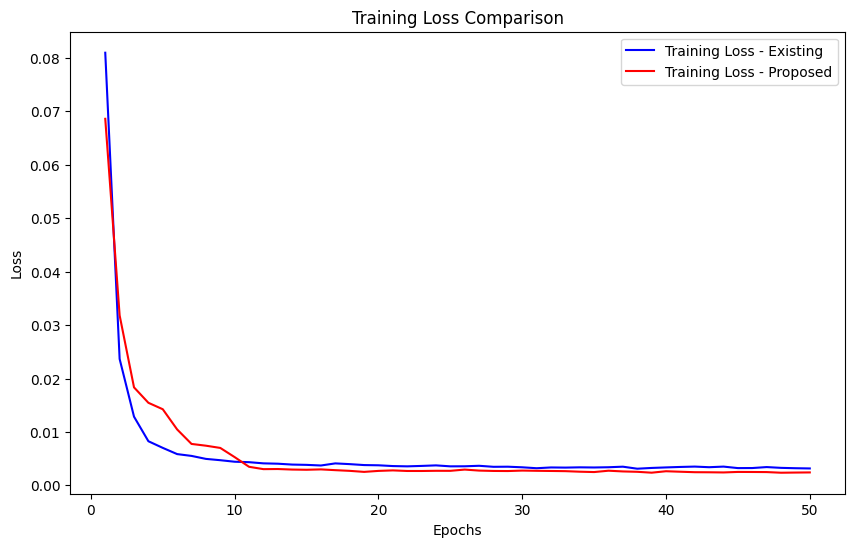

In [ ]:
import csv
loss1 = []
loss2 = []

# File paths
file_path1 = "nuclei_seg_og_kmc_.csv"
file_path2 = "nuclei_seg_trans_kmc_fuse.csv"

# Function to read CSV file and extract loss values
def extract_loss_values(file_path, loss_list):
    with open(file_path, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            loss_list.append(float(row['loss']))

extract_loss_values(file_path1, loss1)
extract_loss_values(file_path2, loss2)

# loss1 = history1.history['loss']
# loss2 = history2.history['loss']

# Plotting the loss values
epochs = range(1, len(loss1) + 1)

plt.figure(figsize=(10, 6))

# Plotting model1 loss
plt.plot(epochs, loss1, 'b-', label='Training Loss - Existing')

# Plotting model2 loss
plt.plot(epochs, loss2, 'r-', label='Training Loss - Proposed')

plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# import csv
# val_loss1 = []
# val_loss2 = []

# # File paths
# file_path1 = "nuclei_seg_og_kmc.csv"
# file_path2 = "nuclei_seg_transedge_kmc.csv"

# # Function to read CSV file and extract loss values
# def extract_loss_values(file_path, loss_list):
#     with open(file_path, 'r') as file:
#         reader = csv.DictReader(file)
#         for row in reader:
#             loss_list.append(float(row['val_loss']))

# extract_loss_values(file_path1, val_loss1)
# extract_loss_values(file_path2, val_loss2)

# # val_loss1 = history1.history['val_loss']
# # val_loss2 = history2.history['val_loss']

# # Plotting the validation loss values
# epochs = range(1, len(val_loss1) + 1)

# plt.figure(figsize=(10, 6))

# # Plotting model1 validation loss
# plt.plot(epochs, val_loss1, 'b-', label='Validation Loss - Existing')

# # Plotting model2 validation loss
# plt.plot(epochs, val_loss2, 'r-', label='Validation Loss - Proposed')

# plt.title('Validation Loss Comparison')
# plt.xlabel('Epochs')
# plt.ylabel('Validation Loss')
# plt.legend()

# plt.show()

In [ ]:
import numpy as np

def iou_metric(y_true_in, y_pred_in):
    labels = y_true_in
    y_pred = y_pred_in

    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))

    intersection = temp1[0]

    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9

    union = union[1:,1:]
    union[union == 0] = 1e-9

    iou = intersection / union
    return iou

def dice_metric(y_true_in, y_pred_in):
    labels = y_true_in
    y_pred = y_pred_in

    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))

    intersection = temp1[0]

    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9

    union = union[1:,1:]
    union[union == 0] = 1e-9

    dice_m = (2*intersection) / union
    return dice_m
def accuracy(y_true, y_pred):
    total_pixels = y_true.size
    correct_pixels = np.sum(y_true == y_pred)
    return correct_pixels / total_pixels


def f1_score(y_true, y_pred):
    true_positive = np.sum(np.logical_and(y_true, y_pred))
    false_positive = np.sum(np.logical_and(np.logical_not(y_true), y_pred))
    false_negative = np.sum(np.logical_and(y_true, np.logical_not(y_pred)))

    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)

    f1 = 2 * (precision * recall) / (precision + recall)
    return f1


def precision(y_true, y_pred):
    true_positive = np.sum(np.logical_and(y_true, y_pred))
    false_positive = np.sum(np.logical_and(np.logical_not(y_true), y_pred))

    precision = true_positive / (true_positive + false_positive)
    return precision

Predicting the masks ===========>
1/1 [==============================] - 1s 651ms/step
Joining the segmented patches to original sized masks ===========>
['0.png', '3.png', '4.png']
Writing segmented masks to image files ===========>


100%|██████████| 3/3 [00:00<00:00, 417.25it/s]

Segmented images are saved in /content/results
Scores for the segmented output ===========>
ID-4  IOU: 0.78, DICE: 0.876 precision: 0.851 accuracy: 0.984 f1_score: 0.876
ID-4  IOU: 0.755, DICE: 0.86 precision: 0.88 accuracy: 0.984 f1_score: 0.86
ID-4  IOU: 0.697, DICE: 0.821 precision: 0.789 accuracy: 0.98 f1_score: 0.821
mean of jaccard:  0.7438379898193008
mean of dice:  0.8526455140465704
mean of accuracy:  0.8400202022539168
mean of precision:  0.982763926188151
mean of f1_score:  0.8526455140465704


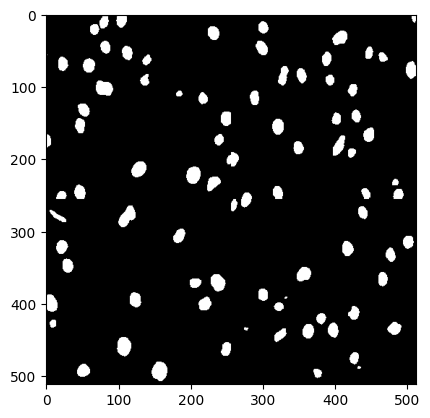

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import numpy as np
import pandas as pd
from statistics import mean
import cv2
import warnings
import tensorflow
from tqdm import tqdm
from tensorflow.keras.callbacks import *
warnings.filterwarnings('ignore')
# Path for the stain normalized image patches normalized image
test_data_path = output_base + '/content/TestData/'
# Path to the full sized test mask for score computation
gt_path = input_base + '/content/drive/MyDrive/NucleiSegNet/KMC_LIverSegmentation/Test/label/'
# Path to model weight and weight name
model_path = output_base + '/content/drive/MyDrive/NucleiSegNet/checkpoint'
weight_name = 'nuclei_seg_og_kmc.keras'
# Path to save the segmented masks
if not os.path.exists(output_base + "/content/results"):
    os.mkdir(output_base + "/content/results")
sv_path = output_base + '/content/results'

# used height and widht for patch
img_width_p = 256
img_height_p = 256
# Full image size
img_width_f = 512
img_height_f = 512

test_generator = DataGeneratorFolder(root_dir = test_data_path,
                                    image_folder = 'tis/',
                                    mask_folder = 'Bin/',
                                    batch_size=1,augmentation = None,
                                    image_size=img_width_p,
                                    nb_y_features = 1)


model = create_model()
model.load_weights(os.path.join(model_path,weight_name))

out_im = []

print('Predicting the masks ===========>')
for tes in test_generator:
    # Xtest_n, y_test_n  = test_generator.__getitem__(tes)
    Xtest_n, y_test_n = tes[0], tes[1]
    predicted = model.predict(np.expand_dims(Xtest_n[0], axis=0)).reshape(img_width_p, img_height_p)
    predicted1= predicted.flatten()
    predicted1[predicted1>=0.5]=1
    predicted1[predicted1<0.5]=0
    predicted2 = predicted1.reshape((img_width_p, img_height_p))
    predicted2 = np.expand_dims(predicted2, -1)
    out_im.append(predicted2)

# Creating full sized segmented image (actual size) from segmented patches
print('Joining the segmented patches to original sized masks ===========>')
out_full1,ids_test1 = patch_join(out_im)
print(ids_test1)

# Writing the masks as image filee to folder
print('Writing segmented masks to image files ===========>')
for n, id_ in tqdm(enumerate(ids_test1), total=len(ids_test1)):

    imgs = np.reshape(out_full1[n]*255,(img_width_f,img_height_f))
    filename = '{}/{}_og_kmc.png'.format(sv_path,os.path.splitext(id_)[0])
    cv2.imwrite(filename, imgs)

print('Segmented images are saved in {}'.format(sv_path))

plt.imshow(out_full1[0]*255, cmap = 'gray')

# Computing scores (DICE and IOU)
print('Scores for the segmented output ===========>')
scr_met = {'IOU':[],'DICE':[], 'prec':[], 'acc':[], 'f1':[]}

for _,i in enumerate(ids_test1):

    gt = gt_path+os.path.splitext(i)[0]+'.png'
    plabel = os.path.join(sv_path,os.path.splitext(i)[0]+'_og_kmc.png')

    true   = cv2.imread(gt,0)
    _, true = cv2.threshold(true, 128, 255, cv2.THRESH_BINARY)
    true = true.astype(bool)
    pred_1 = cv2.imread(plabel,0).astype(bool)

    dice_coeff = dice_metric(true,pred_1)
    jacc_f = iou_metric(true,pred_1)
    acc = accuracy(true, pred_1)
    prec = precision(true, pred_1)
    f1 = f1_score(true, pred_1)

    scr_met['IOU'].append(jacc_f.item())
    scr_met['DICE'].append(dice_coeff.item())
    scr_met['prec'].append(prec)
    scr_met['acc'].append(acc)
    scr_met['f1'].append(f1)
    print('ID-{}  IOU: {:.3}, DICE: {:.3} precision: {:.3} accuracy: {:.3} f1_score: {:.3}'.format(os.path.splitext(id_)[0],jacc_f.item(),dice_coeff.item(), prec, acc, f1))


print("mean of jaccard: ",mean(scr_met['IOU']))
print("mean of dice: ",mean(scr_met['DICE']))
print("mean of accuracy: ",mean(scr_met['prec']))
print("mean of precision: ",mean(scr_met['acc']))
print("mean of f1_score: ",mean(scr_met['f1']))


<class 'tensorflow.python.framework.ops.SymbolicTensor'>
Tensor("patches/ExtractImagePatches:0", shape=(None, 32, 32, 192), dtype=float32)
(None, 1024, 192)


Predicting the masks ===========>
<class 'tensorflow.python.framework.ops.SymbolicTensor'>
Tensor("model_1/patches/ExtractImagePatches:0", shape=(None, 32, 32, 192), dtype=float32)
1/1 [==============================] - 1s 1s/step
Joining the segmented patches to original sized masks ===========>
Writing segmented masks to image files ===========>


100%|██████████| 3/3 [00:00<00:00, 412.12it/s]

Segmented images are saved in /content/results
Scores for the segmented output ===========>
ID-4  IOU: 0.813, DICE: 0.897 precision: 0.881 accuracy: 0.987 f1_score: 0.897
ID-4  IOU: 0.792, DICE: 0.884 precision: 0.896 accuracy: 0.987 f1_score: 0.884
ID-4  IOU: 0.721, DICE: 0.838 precision: 0.794 accuracy: 0.982 f1_score: 0.838
mean of jaccard:  0.7751225433974429
mean of dice:  0.8727551417007587
mean of accuracy:  0.8569562348474546
mean of precision:  0.9850641886393229
mean of f1_score:  0.8727551417007586


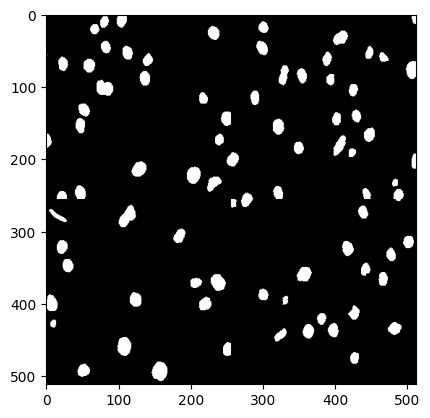

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import numpy as np
import pandas as pd
from statistics import mean
import cv2
import warnings
import tensorflow
from tqdm import tqdm
from tensorflow.keras.callbacks import *

warnings.filterwarnings('ignore')
# Path for the stain normalized image patches normalized image
test_data_path = output_base + '/content/TestData/'
# Path to the full sized test mask for score computation
gt_path = input_base + '/content/drive/MyDrive/NucleiSegNet/KMC_LIverSegmentation/Test/label/'
# Path to model weight and weight name
model_path = output_base + '/content/drive/MyDrive/NucleiSegNet/checkpoint'
weight_name = 'nuclei_seg_trans_kmc_fuse.keras'
# Path to save the segmented masks
if not os.path.exists(output_base + "/content/results"):
    os.mkdir(output_base + "/content/results")
sv_path = output_base + '/content/results'

# used height and widht for patch
img_width_p = 256
img_height_p = 256
# Full image size
img_width_f = 512
img_height_f = 512

test_generator = DataGeneratorFolder(root_dir = test_data_path,
                                    image_folder = 'tis/',
                                    mask_folder = 'Bin/',
                                    batch_size=1,augmentation = None,
                                    image_size=img_width_p,
                                    nb_y_features = 1)


model = create_model_modified()
model.load_weights(os.path.join(model_path,weight_name))

out_im = []

print('Predicting the masks ===========>')
for tes in test_generator:
    # Xtest_n, y_test_n  = test_generator.__getitem__(tes)
    Xtest_n, y_test_n = tes[0], tes[1]
    predicted = model.predict(np.expand_dims(Xtest_n[0], axis=0)).reshape(img_width_p, img_height_p)
    predicted1= predicted.flatten()
    predicted1[predicted1>=0.5]=1
    predicted1[predicted1<0.5]=0
    predicted2 = predicted1.reshape((img_width_p, img_height_p))
    predicted2 = np.expand_dims(predicted2, -1)
    out_im.append(predicted2)


# Creating full sized segmented image (actual size) from segmented patches
print('Joining the segmented patches to original sized masks ===========>')
out_full2,ids_test2 = patch_join(out_im)

# Writing the masks as image file to folder
print('Writing segmented masks to image files ===========>')
for n, id_ in tqdm(enumerate(ids_test2), total=len(ids_test2)):

    imgs = np.reshape(out_full2[n]*255,(img_width_f,img_height_f))
    filename = '{}/{}_edge_kmc.png'.format(sv_path,os.path.splitext(id_)[0])
    cv2.imwrite(filename, imgs)

print('Segmented images are saved in {}'.format(sv_path))

plt.imshow(out_full2[0]*255, cmap = 'gray')

# Computing scores (DICE and IOU)
print('Scores for the segmented output ===========>')
scr_met = {'IOU':[],'DICE':[], 'prec':[], 'acc':[], 'f1':[]}

for _,i in enumerate(ids_test2):

    gt = gt_path+os.path.splitext(i)[0]+'.png'
    plabel = os.path.join(sv_path,os.path.splitext(i)[0]+'_edge_kmc.png')

    true   = cv2.imread(gt,0)
    _, true = cv2.threshold(true, 128, 255, cv2.THRESH_BINARY)
    true = true.astype(bool)
    pred_1 = cv2.imread(plabel,0).astype(bool)

    dice_coeff = dice_metric(true,pred_1)
    jacc_f = iou_metric(true,pred_1)
    acc = accuracy(true, pred_1)
    prec = precision(true, pred_1)
    f1 = f1_score(true, pred_1)

    scr_met['IOU'].append(jacc_f.item())
    scr_met['DICE'].append(dice_coeff.item())
    scr_met['prec'].append(prec)
    scr_met['acc'].append(acc)
    scr_met['f1'].append(f1)
    print('ID-{}  IOU: {:.3}, DICE: {:.3} precision: {:.3} accuracy: {:.3} f1_score: {:.3}'.format(os.path.splitext(id_)[0],jacc_f.item(),dice_coeff.item(), prec, acc, f1))


print("mean of jaccard: ",mean(scr_met['IOU']))
print("mean of dice: ",mean(scr_met['DICE']))
print("mean of accuracy: ",mean(scr_met['prec']))
print("mean of precision: ",mean(scr_met['acc']))
print("mean of f1_score: ",mean(scr_met['f1']))


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
def draw_overlay(tissue_path, bin_path, color):
    # Load tissue image and segmentation mask
    tissue_image = cv2.imread(tissue_path, cv2.COLOR_BGR2RGB)
    segmentation_mask = cv2.imread(bin_path, cv2.IMREAD_GRAYSCALE)
    plt.imshow(tissue_image)
    plt.show()

    # Create a copy of the tissue image for drawing the boundaries
    result_image = tissue_image.copy()

    # Find contours in the segmentation mask
    contours, _ = cv2.findContours(segmentation_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw green boundaries around nuclei
    for contour in contours:
        # Approximate the contour to reduce the number of points
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        # Draw green contour
        cv2.drawContours(result_image, [approx], -1, color, 2)

    # Display or save the resulting image
    plt.imshow(result_image)
    plt.show()


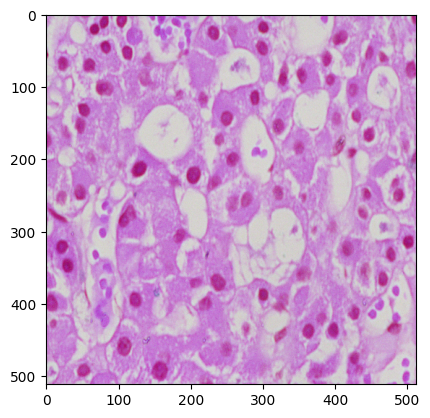

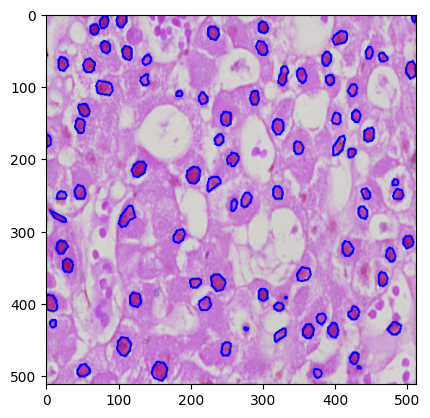

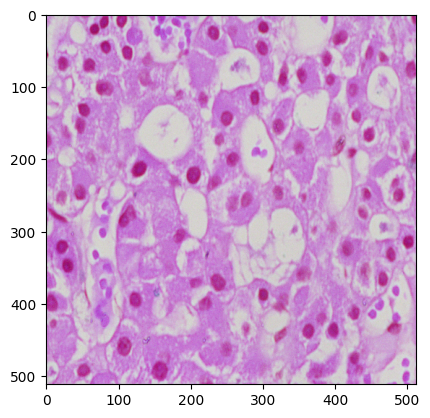

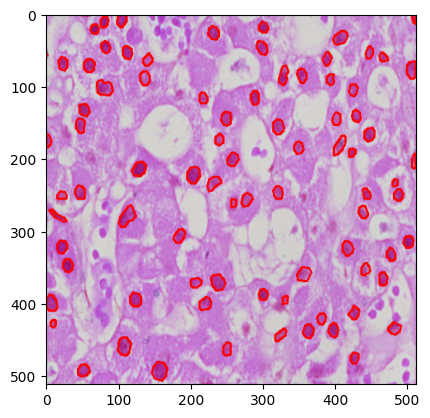

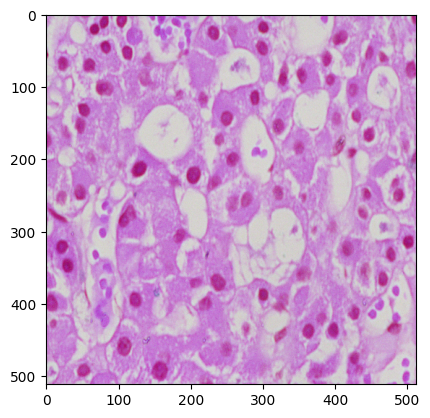

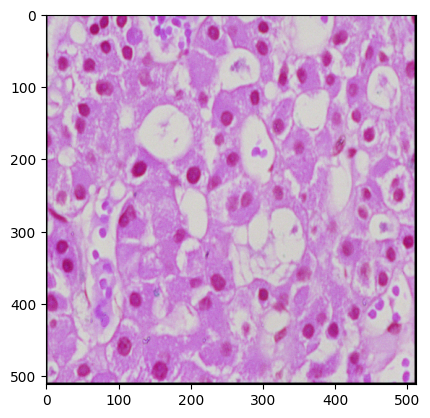

In [ ]:
predicted_mask1 = '{}/{}_og_kmc.png'.format(sv_path,os.path.splitext(ids_test1[0])[0])
predicted_mask2 = '{}/{}_edge_kmc.png'.format(sv_path,os.path.splitext(ids_test2[0])[0])
tissue = input_base + "/content/drive/MyDrive/NucleiSegNet/KMC_LIverSegmentation/Test/data/{}.png".format(os.path.splitext(ids_test1[0])[0])
gt = input_base + "/content/drive/MyDrive/NucleiSegNet/KMC_LIverSegmentation/Test/label/{}.png".format(os.path.splitext(ids_test1[0])[0])
draw_overlay(tissue, predicted_mask1, (0, 0, 255))
draw_overlay(tissue, predicted_mask2, (255, 0, 0))
draw_overlay(tissue, gt, (0, 0, 0))